In this project I trained four models, (1) a simple convolutional neural network (CNN) with two convolutional layers and one fully connected layer, denoted by *simplenet*, (2) a CNN with three convolutionallayers and one fully connected layer, denoted by *mynet*, (3) a pretrained model ResNet18 where I froze all layerers except the last layer, *resnet*, and (4) EfficientNet-B0 where the last layer was not frozen and trainable, *effnet*.

The baseline configurations for these four models were no data augmentation, a *learning_rate* of 0.001, and a *batch_size* of 64. 

Modifications were applied individually to evaluate their impact: applying data augmentation, increasing the learning rate to 0.01, and reducing the batch size to 32.

##### 1. Training time of different algorithms under different settings

In [35]:
def plot_runtime(directory, setting):
    ''' Plot runtimes from .csv files in a directory '''
    
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    runtimes = {}

    for file in os.listdir(directory):
        if 'runtime' in file:
            filepath = os.path.join(directory, file)
            df = pd.read_csv(filepath)
            model_name = file.replace('runtime_', '').replace('.csv', '')
            runtimes[model_name] = df.iloc[:, 0].values
    
    plt.figure(figsize=(5, 3))
    for model_name, runtime_values in runtimes.items():
        plt.plot(runtime_values, label=model_name)
    plt.title(f'Model Runtime Comparison - {setting}')
    plt.xlabel('Epoch')
    plt.ylabel('Runtime (secs)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

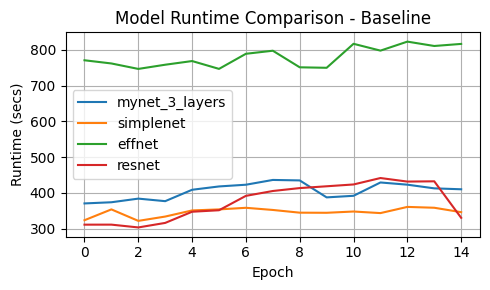

In [36]:
plot_runtime('result', 'Baseline')

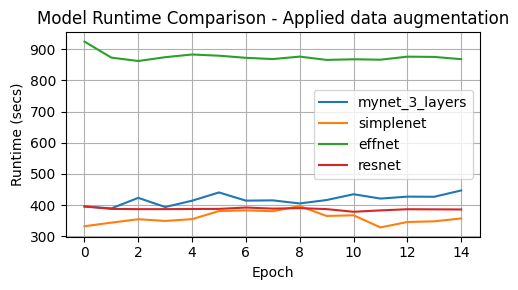

In [37]:
plot_runtime('result_augment', 'Applied data augmentation')

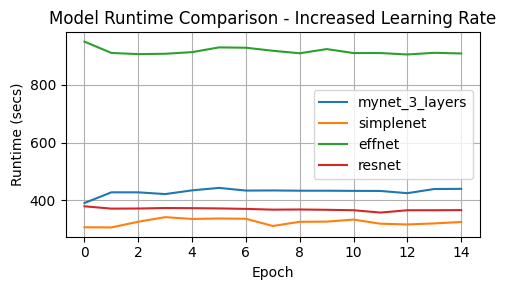

In [38]:
plot_runtime('result_lr', 'Increased Learning Rate')

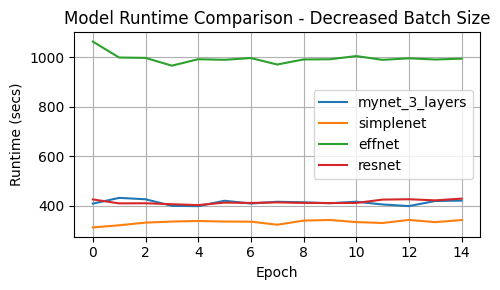

In [39]:
plot_runtime('result_batchsize', 'Decreased Batch Size')

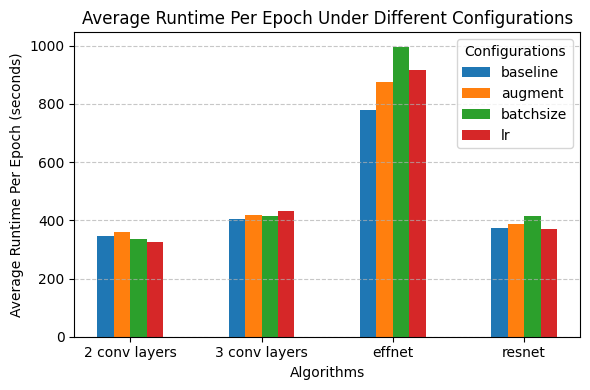

In [ ]:
def plot_runtime_histogram(folders):
    '''
    Plot a histogram of average runtimes from CSV files across multiple folders.
    '''
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # a dictictionary of dictionaries, 
    # where keys are folder names representing different configurations
    # and values are dictionaries containing pairs of model_name: avg_runtime
    runtimes = {}  

    for folder in folders:
        runtimes[folder] = {}

        for file in os.listdir(folder):
            if "runtime" in file:
                filepath = os.path.join(folder, file)
                df = pd.read_csv(filepath)
                
                model_name = file.replace('runtime_', '').replace('.csv', '')  # Extract model name from file
                if model_name == 'simplenet':
                    model_name = '2 conv layers'
                if model_name == 'mynet_3_layers':
                    model_name = '3 conv layers'
        
                avg_runtime = df.values.mean()  # Calculate the average runtime
                runtimes[folder][model_name] = avg_runtime

    # Prepare data for plotting
    models = set(model for folder_data in runtimes.values() for model in folder_data.keys())
    models = sorted(models)  # Sort model names for ordering, ['effnet', 'mynet', 'resnet']
    
    x = np.arange(len(models))  # X-axis positions for models under a configuration
    width = 0.5 / len(folders)  # Bar width for each folder/configuration
    
    plt.figure(figsize=(6, 4))
    
    for i, (folder, folder_data) in enumerate(runtimes.items()):
        # Align bars for each folder
        y = [folder_data.get(model, 0) for model in models]
        label = folder.replace('result_', '') if 'result_' in folder else 'baseline'
        plt.bar(x = x + i*width, height=y, width=width, label=label)

    plt.title("Average Runtime Per Epoch Under Different Configurations")
    plt.xlabel("Algorithms")
    plt.ylabel("Average Runtime Per Epoch (seconds)")
    plt.xticks(x + width * (len(folders) - 1) / 2, models)  # Center xticks
    plt.legend(title="Configurations")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
folders = ["result", "result_augment", "result_batchsize", "result_lr"]
plot_runtime_histogram(folders)

**Findings**:

The graph shows that EfficientNet-B0 took the most time to train, whereas simplenet took the least. Batch size, data augmentation, and learning rate had different effects on algorithms. Model achitectures, which correspond to the number of parameters, was the sole factor in training time.

##### 2. Performance of different algorithms under different configurations
For the sake of conciseness, performance was in terms of the training loss and validation accuracy (at the final epoch) only.

In [20]:
def plot_metrics_subplots(folders=["result", "result_augment", "result_batchsize", "result_lr"]):
    '''
    Plot training loss and validation accuracy for models across different settings in two subplots.
    '''
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MultipleLocator  # Import for dense grid lines

    metrics = {"Training Loss": {}, "Validation Accuracy": {}}  # Store metrics by folder

    # 1. Load data from each folder
    for folder in folders:
        folder_label = os.path.basename(folder)  # Use folder name as label
        
        for file in os.listdir(folder):
            if file.endswith(".csv"):
                filepath = os.path.join(folder, file)

                # Determine metric type 
                if "losses_train" in file:
                    metric_type = "Training Loss"
                elif "accus_valid" in file:
                    metric_type = "Validation Accuracy"
                else:
                    continue
                
                # Determine model name
                model_name = file.split("_")[-1].replace(".csv", "")  # Extract model name from file name
                if model_name == 'layers':
                    model_name = "3 conv layers"
                if model_name == 'simplenet':
                    model_name = "2 conv layers"
                
                # Get the metric value
                df = pd.read_csv(filepath)
                metric = df.iloc[-1, 0]  #use the metric at last epoch
                
                # Store the metric
                if model_name not in metrics[metric_type]:
                    metrics[metric_type][model_name] = {}
                metrics[metric_type][model_name][folder_label] = metric
    
    print(metrics)

    # 2. Get a sorted list of models and folders
    models = sorted(set(model for metric_data in metrics.values() for model in metric_data.keys()))
    folder_labels = sorted(folders, key=lambda x: os.path.basename(x))

    x = np.arange(len(models))  # X-axis positions for models
    width = 0.45 / len(folder_labels)  # Bar width for each folder

    # 3. Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # 3.1 Plot each metric on a separate subplot
    for ax, (metric_type, metric_data) in zip(axes, metrics.items()):
        for j, folder_label in enumerate(folder_labels):
            y = [metric_data[model].get(folder_label, 0) for model in models]
            ax.bar(x=x + j * width, height=y, width=width,
                   label=f"{folder_label.replace('result_', '') if 'result_' in folder_label else 'baseline'}")

        ax.set_title(f"{metric_type} (Final Epoch)")
        ax.set_ylabel("Loss" if "Loss" in metric_type else "Accuracy")
        ax.legend(title="Settings")
        ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    # 3.2 Add horizontal grid lines with more density
    ax.yaxis.set_major_locator(MultipleLocator(0.15))  # Adjust the step size for grid lines

    # 3.3 Configure the shared x-axis
    axes[-1].set_xticks(x + width * (len(folder_labels) - 1) / 2)
    axes[-1].set_xticklabels(models)
    axes[-1].set_xlabel("Algorithms")

    # 3.4 Finalize layout and display
    plt.tight_layout()
    plt.show()

{'Training Loss': {'resnet': {'result': 0.0914029011758148, 'result_augment': 0.6536958633643116, 'result_batchsize': 0.0533695604160503, 'result_lr': 0.1798715102888152}, 'effnet': {'result': 0.0352410923613963, 'result_augment': 0.5312845147200648, 'result_batchsize': 0.0143863809458098, 'result_lr': 0.1143861028441431}, '2 conv layers': {'result': 0.030645854, 'result_augment': 2.050199639, 'result_batchsize': 0.03242992, 'result_lr': 4.60304528}, '3 conv layers': {'result': 0.037308186, 'result_augment': 1.440364898, 'result_batchsize': 0.059843502, 'result_lr': 4.602736413}}, 'Validation Accuracy': {'effnet': {'result': 0.926, 'result_augment': 0.73, 'result_batchsize': 0.916, 'result_lr': 0.87}, '3 conv layers': {'result': 0.578, 'result_augment': 0.744, 'result_batchsize': 0.548, 'result_lr': 0.01}, 'resnet': {'result': 0.92, 'result_augment': 0.858, 'result_batchsize': 0.912, 'result_lr': 0.854}, '2 conv layers': {'result': 0.42, 'result_augment': 0.574, 'result_batchsize': 0.4

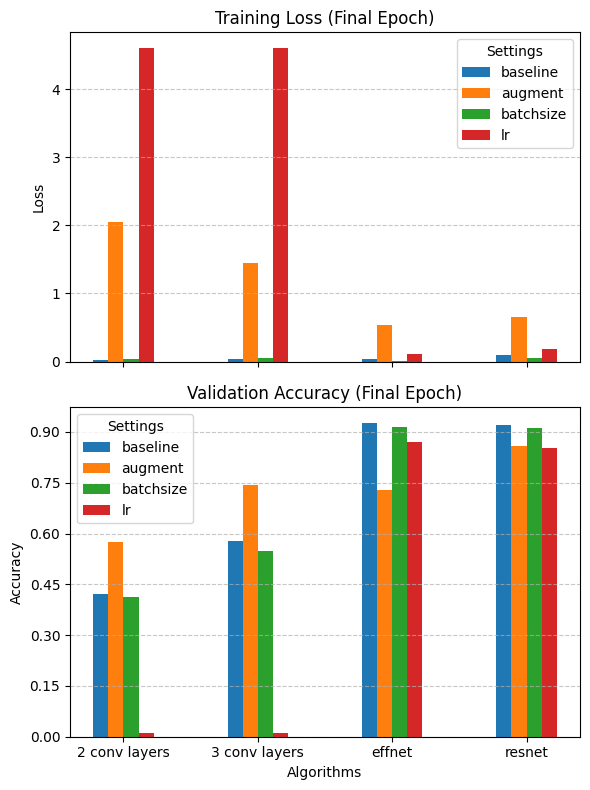

In [21]:
plot_metrics_subplots()

**Findings**:

(1) Overall, pretained models (*resnet* and *effnet*)were more accurate than custom models (*3layers* and *simplenet*), and *3layers*, a custom network with three convolutional layers, was better than *simplenet*, which has two layers. 

(2) Applying data agmentation increased the Accuracy of the custom models but decreased that of the pretrained models. 

(3) Batch size had no obvious effects on the models' performance. 

(4) Increasing the learning rate strongly worsened the performance of the custom models while having no noticeable effects on pretraiend models. 

In [71]:
def plot_metrics_line_graph(model_name, folders=["result", "result_augment", "result_batchsize", "result_lr"]):
    '''
    Plot training loss and validation accuracy over epochs for a specific model across multiple settings 
    on a single plot with two Y-axes.
    
    Args:
    - model_name (str): The model name to plot (e.g., 'effnet').
    - folders (list of str): List of folder paths containing metric CSV files.
    '''

    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    
    data = []  # To store data from all folders

    # Load data from each folder
    for folder in folders:
        loss_file = None
        acc_file = None
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            if f"losses_train_{model_name}" in file:
                loss_file = filepath
            elif f"accus_valid_{model_name}" in file:
                acc_file = filepath
        
        if loss_file and acc_file:
            losses = pd.read_csv(loss_file).values.flatten().tolist()  # Get loss values
            accus = pd.read_csv(acc_file).values.flatten().tolist()   # Get accuracy values
            data.append((folder, losses, accus))  # Store folder name, losses, and accuracies

    # Plot
    fig, ax1 = plt.subplots(figsize=(7, 5))
    ax2 = ax1.twinx()
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Define colors for each setting
    
    for i, (folder, losses, accus) in enumerate(data):
        epochs = range(1, len(losses) + 1)
        color_loss = colors[i % len(colors)]  # Color for loss
        color_acc = colors[i % len(colors)]  # Same color for accuracy to match settings

        # Plot training loss
        label = folder.replace('result_', '') if 'result_' in folder else 'baseline'
        ax1.plot(epochs, losses, label=label, color=color_loss, linestyle='--')
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Training Loss")

        # Plot validation accuracy on secondary axis
        ax2.plot(epochs, accus, label=label, color=color_acc)
        ax2.set_ylabel("Validation Accuracy")

    ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Reduce number of ticks

    # Title, legend, and grid
    fig.suptitle(f"Loss and Accuracy Over Epochs for {model_name} Across Settings")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.grid(linestyle="--", alpha=0.7)
    fig.tight_layout()
    plt.show()

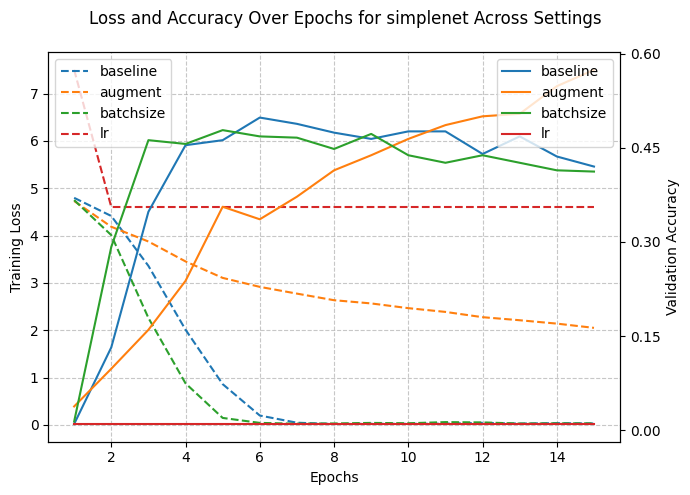

In [72]:
plot_metrics_line_graph("simplenet")

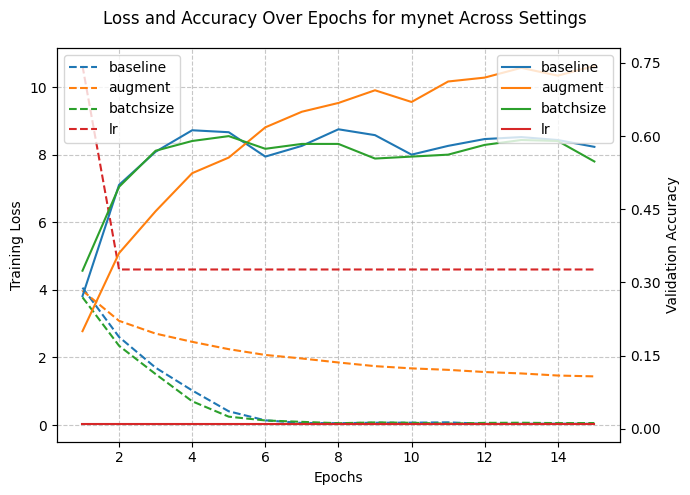

In [75]:
plot_metrics_line_graph("mynet")

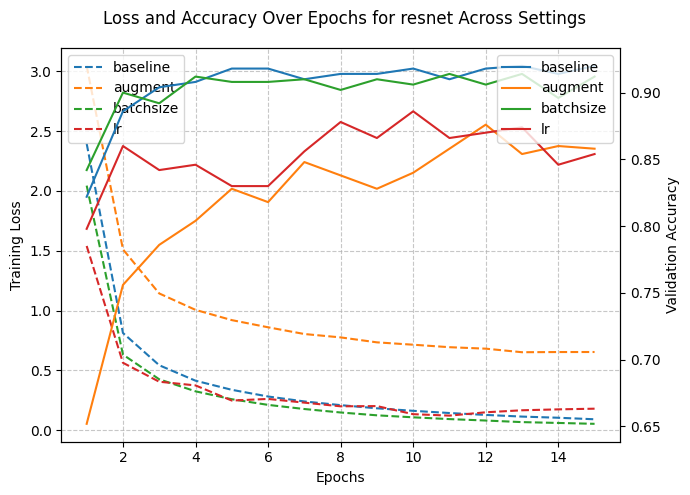

In [74]:
plot_metrics_line_graph("resnet")

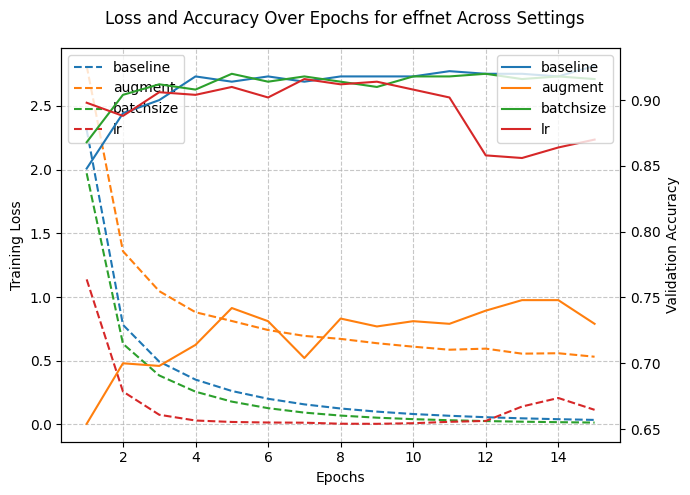

In [73]:
plot_metrics_line_graph("effnet")

In [45]:
metrcis = {'Training Loss': {'resnet': {'result': 0.0914029011758148, 'result_augment': 0.6536958633643116, 'result_batchsize': 0.0533695604160503, 'result_lr': 0.1798715102888152}, 'effnet': {'result': 0.0352410923613963, 'result_augment': 0.5312845147200648, 'result_batchsize': 0.0143863809458098, 'result_lr': 0.1143861028441431}, '2 conv layers': {'result': 0.030645854, 'result_augment': 2.050199639, 'result_batchsize': 0.03242992, 'result_lr': 4.60304528}, '3 conv layers': {'result': 0.037308186, 'result_augment': 1.440364898, 'result_batchsize': 0.059843502, 'result_lr': 4.602736413}},
           'Validation Accuracy': {'effnet': {'result': 0.926, 'result_augment': 0.73, 'result_batchsize': 0.916, 'result_lr': 0.87}, '3 conv layers': {'result': 0.578, 'result_augment': 0.744, 'result_batchsize': 0.548, 'result_lr': 0.01}, 'resnet': {'result': 0.92, 'result_augment': 0.858, 'result_batchsize': 0.912, 'result_lr': 0.854}, '2 conv layers': {'result': 0.42, 'result_augment': 0.574, 'result_batchsize': 0.412, 'result_lr': 0.01}}}

import numpy as np
n = 500  # number of samples in the validation set (100 classes * 5 images)
critval = 1.96 

for model_name, accu_dict in metrcis['Validation Accuracy'].items():
    print(model_name, ':', accu_dict)
    for setting, accu in accu_dict.items():
        print(setting, ': Accuracy:', accu)
        
        rawdata = np.zeros(n)
        correct = int(accu * n)
        rawdata[range(correct)] = 1

        SE = np.std(rawdata, ddof=1) / np.sqrt(n)
        norm_ci = [accu - critval * SE,
                   accu + critval * SE]
        print(setting, ': CI:', norm_ci, '\n')

effnet : {'result': 0.926, 'result_augment': 0.73, 'result_batchsize': 0.916, 'result_lr': 0.87}
result : Accuracy: 0.926
result : CI: [0.9030317899228456, 0.9489682100771545] 

result_augment : Accuracy: 0.73
result_augment : CI: [0.6910462645306765, 0.7689537354693234] 

result_batchsize : Accuracy: 0.916
result_batchsize : CI: [0.8916615353293383, 0.9403384646706617] 

result_lr : Accuracy: 0.87
result_lr : CI: [0.8404921816684905, 0.8995078183315095] 

3 conv layers : {'result': 0.578, 'result_augment': 0.744, 'result_batchsize': 0.548, 'result_lr': 0.01}
result : Accuracy: 0.578
result : CI: [0.5346662829511876, 0.6213337170488124] 

result_augment : Accuracy: 0.744
result_augment : CI: [0.7057076297934946, 0.7822923702065054] 

result_batchsize : Accuracy: 0.548
result_batchsize : CI: [0.5043317995486267, 0.5916682004513734] 

result_lr : Accuracy: 0.01
result_lr : CI: [0.0012698160257386976, 0.0187301839742613] 

resnet : {'result': 0.92, 'result_augment': 0.858, 'result_batchsi

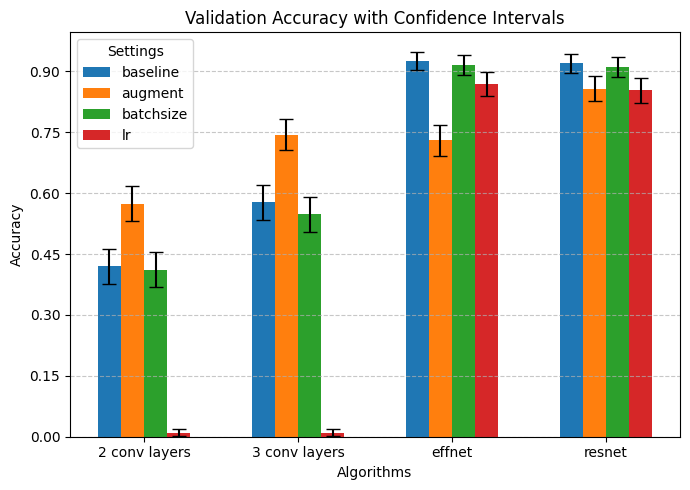

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Data
metrics = {
    'Validation Accuracy': {
        '2 conv layers': {'baseline': 0.42, 'augment': 0.574, 'batchsize': 0.412, 'lr': 0.01},
        '3 conv layers': {'baseline': 0.578, 'augment': 0.744, 'batchsize': 0.548, 'lr': 0.01},
        'effnet': {'baseline': 0.926, 'augment': 0.73, 'batchsize': 0.916, 'lr': 0.87},
        'resnet': {'baseline': 0.92, 'augment': 0.858, 'batchsize': 0.912, 'lr': 0.854},
        
    }
}

n = 500  # Number of samples
critval = 1.96  # Critical value for 95% confidence interval

# Prepare data
models = list(metrics['Validation Accuracy'].keys())
settings = list(next(iter(metrics['Validation Accuracy'].values())).keys())

# Initialize storage
accuracy_values = []
ci_errors = []

# Calculate means and errors
for model_name, accu_dict in metrics['Validation Accuracy'].items():
    acc_values = []
    errors = []
    for setting, accu in accu_dict.items():
        SE = np.sqrt((accu * (1 - accu)) / n)  # Standard error
        ci = [accu - critval * SE, accu + critval * SE]
        acc_values.append(accu)
        errors.append((ci[1] - ci[0]) / 2)  # Half-width for error bars
    accuracy_values.append(acc_values)
    ci_errors.append(errors)

accuracy_values = np.array(accuracy_values)
ci_errors = np.array(ci_errors)

# Plotting
x = np.arange(len(models))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(7, 5))

for i, setting in enumerate(settings):
    ax.bar(
        x + i * bar_width, 
        accuracy_values[:, i], 
        width=bar_width, 
        label=setting,
        yerr=ci_errors[:, i],  # Add error bars
        capsize=5  # Add caps to error bars
    )

from matplotlib.ticker import MultipleLocator  # Import for dense grid lines
ax.yaxis.set_major_locator(MultipleLocator(0.15))  # Adjust the step size for grid lines

# Labels and formatting
ax.set_title("Validation Accuracy with Confidence Intervals")
ax.set_xlabel("Algorithms")
ax.set_ylabel("Accuracy")
ax.set_xticks(x + bar_width * (len(settings) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title="Settings")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()